# Teleco Churn Prediction
This notebook uses a dataset from Teleco detailing various data about its consumers, and ultimately whether they left for another provider or not. I use pandas to manipulate the data, and use sklearn to create a random forest classifier about whether a user will churn or not with about 80% accuracy. I then set the default threshold higher than normal to shift the model in favor of precision at the cost of recall, as there are limited resources to deal with customers likely to churn. Thus, taking a smaller sample of higher likelyhood churn customers is beneficial here.
## Dependencies
Pandas

Numpy

Matplotlib

Scikit-Learn
## Author
Scott Little

Github: https://github.com/ScottMoffatLittle/TelcoChurnPrediction.git

Email: sml029@bucknell.edu

June 7, 2019

## Read In Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./data_cust_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Format and Scale Data

In [3]:
#Drop Customer ID, does not correlate
df = df.drop('customerID', axis=1)
df_test = df.copy()

#Convert text values to numbers
df['gender'] = df['gender'].map( {'Male':0, 'Female':1} )
df['Partner'] = df['Partner'].map( {'No':0, 'Yes':1} )
df['Dependents'] = df['Dependents'].map( {'No':0, 'Yes':1} )
df['PhoneService'] = df['PhoneService'].map( {'No':0, 'Yes':1} )
df['MultipleLines'] = df['MultipleLines'].map( {'No':0, 'No phone service':0, 'Yes':1} )
df['InternetService'] = df['InternetService'].map( {'No':0, 'DSL':1, 'Fiber optic':2} )
df['OnlineSecurity'] = df['OnlineSecurity'].map( {'No':0, 'No internet service':0, 'Yes':1} )
df['OnlineBackup'] = df['OnlineBackup'].map( {'No':0, 'No internet service':0, 'Yes':1} )
df['DeviceProtection'] = df['DeviceProtection'].map( {'No':0, 'No internet service':0, 'Yes':1} )
df['TechSupport'] = df['TechSupport'].map( {'No':0, 'No internet service':0, 'Yes':1} )
df['StreamingTV'] = df['StreamingTV'].map( {'No':0, 'No internet service':0, 'Yes':1} )
df['StreamingMovies'] = df['StreamingMovies'].map( {'No':0, 'No internet service':0, 'Yes':1} )
df['PaperlessBilling'] = df['PaperlessBilling'].map( {'No':0, 'Yes':1} )
df['PaymentMethod'] = df['PaymentMethod'].map( {'Mailed check':0, 'Electronic check':1, \
    'Credit card (automatic)':2, 'Bank transfer (automatic)':3} )
df['Churn'] = df['Churn'].map( {'No':0, 'Yes':1} )
df['Contract'] = df['Contract'].map( {'Month-to-month':0, 'One year':1, 'Two year':2} )

#substitute missing values in dataframe with nan
df = df.replace(r'^\s+$', np.nan, regex=True)
df_test = df_test.replace(r'^\s+$', np.nan, regex=True)

#fill nan values in TotalCharges with 1000
df['TotalCharges'] = df['TotalCharges'].fillna(1000.0)
df_test['TotalCharges'] = df_test['TotalCharges'].fillna(1000.0)

#Scale total and monthly charges logorithmically
df['MonthlyCharges'] = df['MonthlyCharges'].apply(np.log)
df['TotalCharges'] = df['TotalCharges'].astype(float).apply(np.log)
df_test['MonthlyCharges'] = df_test['MonthlyCharges'].apply(np.log)
df_test['TotalCharges'] = df_test['TotalCharges'].astype(float).apply(np.log)


df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1,3.396185,3.396185,0
1,0,0,0,0,34,1,0,1,1,0,1,0,0,0,1,0,0,4.042174,7.544068,0
2,0,0,0,0,2,1,0,1,1,1,0,0,0,0,0,1,0,3.986202,4.683519,1
3,0,0,0,0,45,0,0,1,1,0,1,1,0,0,1,0,3,3.744787,7.517928,0
4,1,0,0,0,2,1,0,2,0,0,0,0,0,0,0,1,1,4.258446,5.021575,1


## Create Baseline Model

In [4]:
#Split the dataset into a train and test set
X = df.drop('Churn', axis=1)
Y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

In [5]:
#Random Forest Model - fit model and predict on test data

random_forest = RandomForestClassifier(n_estimators=100)
model = random_forest.fit(X_train, y_train)
y_model = random_forest.predict(X_test)


## Baseline Model Statistics

In [6]:
#Get accuracy of model
accuracy_score(y_test, y_model)

0.8023850085178875

In [7]:
#Show the precision, recall, f1-score, and support of the model
print(classification_report(y_test, y_model))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1327
           1       0.62      0.52      0.57       434

    accuracy                           0.80      1761
   macro avg       0.73      0.71      0.72      1761
weighted avg       0.79      0.80      0.80      1761



In [8]:
#Create graph of precision vs recall to help place the threshold in the correct spot to tune the model.
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

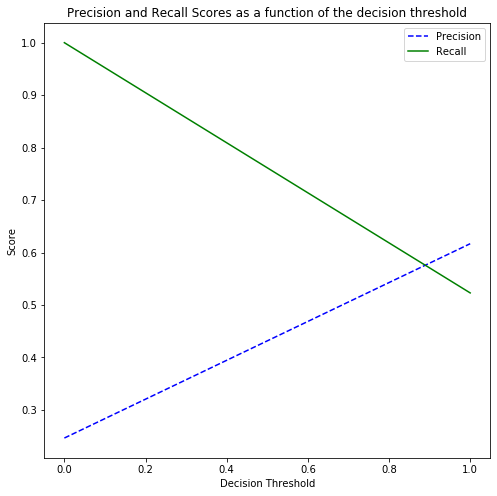

In [9]:
p, r, thresholds = precision_recall_curve(y_test, y_model)
plot_precision_recall_vs_threshold(p, r, thresholds)

## Improving The Model
Shift the default threshold right (to 0.58 from 0.5) so that the model is more precise, with lower recall. This means that on average, two thids of selected customers would have churned, and 44 percent of total customers who will churn are selected

In [10]:
y_model = (model.predict_proba(X_test)[:,1] >= 0.58).astype(bool)
print(classification_report(y_test, y_model))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1327
           1       0.67      0.45      0.54       434

    accuracy                           0.81      1761
   macro avg       0.75      0.69      0.71      1761
weighted avg       0.80      0.81      0.80      1761



## Model Analytics

In [11]:
# Accuracy of new model - slightly higher than the previous one
accuracy_score(y_test, y_model)

0.8097671777399205

In [12]:
#Print the features that contributed to the model most, in order
#TotalCharges, MonthlyCharges were by far the largest contributors.
#This makes sense, because if people are paying a lot, they are likely to leave for a cheaper contract.
#Tenure as the third largest contributor makes sense as well as 
#If they have been with Teleco for a long time they are more likely to stay
features = list(df.columns.values)
importances = model.feature_importances_
feature_importances = dict(zip(features, importances))
sorted_features = sorted(feature_importances, key=feature_importances.get, reverse = True)
sorted_importances = sorted(importances, reverse=True)

for i,j in zip(sorted_features, sorted_importances):
    print("%s\t%s" % (i.ljust(18, " "), j.round(4)))

TotalCharges      	0.1995
MonthlyCharges    	0.1884
tenure            	0.1595
Contract          	0.0858
PaymentMethod     	0.053
InternetService   	0.0512
gender            	0.0276
PaperlessBilling  	0.0252
Partner           	0.0233
OnlineSecurity    	0.022
SeniorCitizen     	0.0215
OnlineBackup      	0.0207
TechSupport       	0.0207
MultipleLines     	0.0198
DeviceProtection  	0.0195
Dependents        	0.019
StreamingMovies   	0.0189
StreamingTV       	0.0174
PhoneService      	0.0069


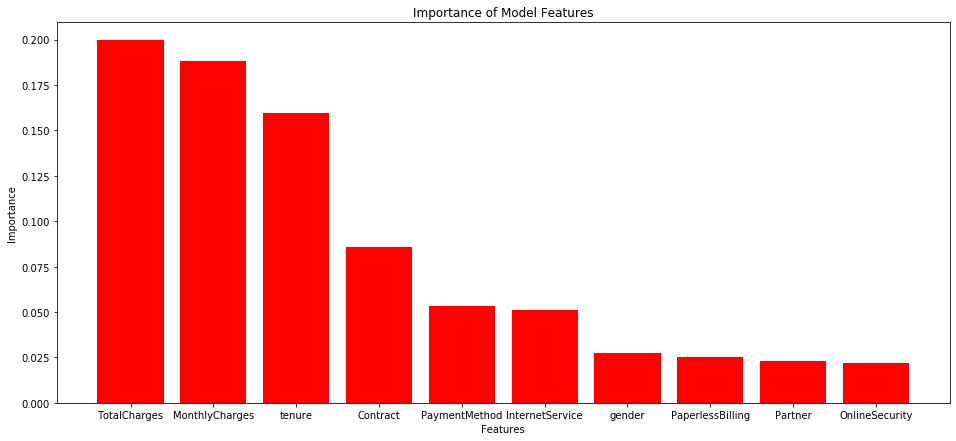

In [13]:
#Show the most important features graphically
x_pos = [i for i, _ in enumerate(sorted_features[:10])]

plt.figure(figsize=(16,7))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.bar(x_pos, sorted_importances[:10], color='red')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Importance of Model Features")
plt.xticks(x_pos, sorted_features[:10])

plt.show()

In [14]:
def churn_analysis_by_feature(crosstab):
    n_rows = len(crosstab.index)
    for row in range(n_rows):
        print(crosstab[1][row]/ (crosstab[0][row] + crosstab[1][row]))


In [15]:
#Number of customers that churn based on level of total charges
labels = ["low", "low/med", "medium", "med/high", "high"]
test_df = df.copy()

test_df['TotalBinned'] = pd.cut(df['TotalCharges'], bins=5, labels=labels)
total_crosstab = pd.crosstab(test_df['TotalBinned'], test_df['Churn'])
pd.crosstab(test_df['TotalBinned'], df_test['Churn'])

Churn,No,Yes
TotalBinned,,
low,270,195
low/med,371,395
medium,870,366
med/high,1613,492
high,2050,421


In [16]:
#Percentage of customers that churn based on level of total charges
churn_analysis_by_feature(total_crosstab)

0.41935483870967744
0.5156657963446475
0.2961165048543689
0.233729216152019
0.17037636584378793


In [17]:
#Number of customers that churn based on level of monthly charges
test_df['MonthlyBinned'] = pd.cut(df['MonthlyCharges'], bins=5, labels=labels)
monthly_crosstab = pd.crosstab(test_df['MonthlyBinned'], test_df['Churn'])
pd.crosstab(test_df['MonthlyBinned'], df_test['Churn'])

Churn,No,Yes
MonthlyBinned,,
low,1456,148
low/med,141,57
medium,670,261
med/high,1287,569
high,1620,834


In [18]:
#Percentage of customers that churn based on level of monthly charges
churn_analysis_by_feature(monthly_crosstab)

0.09226932668329177
0.2878787878787879
0.280343716433942
0.30657327586206895
0.33985330073349634


In [19]:
#Number of customers that churn based on the length of their tenure with Telco
test_df['TenureBinned'] = pd.cut(df['tenure'], bins=5, labels=labels)
tenure_crosstab = pd.crosstab(test_df['TenureBinned'], test_df['Churn'])
pd.crosstab(test_df['TenureBinned'], df_test['Churn'])

Churn,No,Yes
TenureBinned,,
low,1272,1099
low/med,831,295
medium,774,215
med/high,805,142
high,1492,118


In [20]:
#Percentage of customers that churn based on the length of their tenure with Telco
churn_analysis_by_feature(tenure_crosstab)

0.46351750316322227
0.2619893428063943
0.21739130434782608
0.14994720168954592
0.07329192546583851


In [21]:
#Number of customers that churn based on their contract type
contract_crosstab = pd.crosstab(df_test['Contract'], test_df['Churn'])
pd.crosstab(df_test['Contract'], df_test['Churn'])

Churn,No,Yes
Contract,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


In [22]:
#Percentage of customers that churn based on their contract type
churn_analysis_by_feature(contract_crosstab)

0.4270967741935484
0.11269517990495587
0.02831858407079646


In [23]:
#Number of customers that churn based on their internet service type
internet_crosstab = pd.crosstab(df_test['InternetService'], test_df['Churn'])
pd.crosstab(df_test['InternetService'], df_test['Churn'])

Churn,No,Yes
InternetService,,
DSL,1962,459
Fiber optic,1799,1297
No,1413,113


In [24]:
#Percentage of customers that churn based on their internet service type
churn_analysis_by_feature(internet_crosstab)

0.1895910780669145
0.4189276485788114
0.07404980340760157


In [25]:
#Number of customers that churn based on their payment method
pay_method_crosstab = pd.crosstab(df_test['PaymentMethod'], test_df['Churn'])
pd.crosstab(df_test['PaymentMethod'], df_test['Churn'])

Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),1286,258
Credit card (automatic),1290,232
Electronic check,1294,1071
Mailed check,1304,308


In [26]:
#Percent of customers that churn based on their payment method
churn_analysis_by_feature(pay_method_crosstab)

0.16709844559585493
0.15243101182654403
0.4528541226215645
0.19106699751861042


In [27]:
#Number of customers that churn based on gender
gender_crosstab = pd.crosstab(df['gender'], df['Churn'])
pd.crosstab(df_test['gender'], df_test['Churn'])

Churn,No,Yes
gender,,
Female,2549,939
Male,2625,930


In [28]:
#percentage of customers that churn based on gender. Females Churn more than males
churn_analysis_by_feature(gender_crosstab)

0.2616033755274262
0.26920871559633025
